In [73]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

class ColorPredictor(nn.Module):
  def __init__(self):
    super(ColorPredictor, self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(2,512),
        nn.ReLU(),
        
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.layers(x)

def train(model, X, y, epochs=1000):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  scheduler = StepLR(optimizer, step_size=50, gamma=0.7)
  batch_size = 4096 * 4
  dataset = torch.utils.data.TensorDataset(X,y)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

  lossF = nn.MSELoss()

  for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = lossF(pred, batch_y)
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}, Output Range: {pred.min().item():.4f} to {pred.max().item():.4f}")
    scheduler.step()


# torch.manual_seed(42)

def generate_training_data(image_path, max_width=800, max_height=600):
  image = Image.open(image_path)

  image = image.convert('RGB')
  original_width, original_height = image.size
  # Calculate the aspect ratio
  aspect_ratio = original_width / original_height
  # Determine new dimensions while maintaining aspect ratio
  
  if original_width > original_height:
    new_width = max_width
    new_height = int(new_width / aspect_ratio)
  else:
    new_height = max_height
    new_width = int(new_height * aspect_ratio)
  print(f"image with {original_width} height {original_height}")
  print(f"new image with {new_width} height {new_height}")
  image = image.resize((new_width, new_height))
  pixels = np.array(image)/255.0
  X = []
  y = []
  for h in range(image.height):
    for w in range(image.width):
      y.append(pixels[h, w])
    
      wn = (w*1.0/image.width) * 2 - 1
      hn = (h*1.0/image.height) * 2 - 1
      X.append([wn, hn])
      

  return (torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(np.array(y, np.float32)))

def generate_image(model, width, height):
    model.eval()
    image = np.zeros((height, width, 3), dtype=np.uint32)
    cs = []
    for i in range(width):
        for j in range(height):
            cs.append([(i*1.0/width)*2-1, (j*1.0/height)*2-1])
    cs_tensor = torch.FloatTensor(cs)
    pred = model(cs_tensor.to(device)).cpu()

    for c,color in zip(cs, pred):
        color_value = color.detach().numpy()
        # converted_color_value = color_value.astype(np.uint32)
        converted_color_value = color_value
        # print(f"color value {color_value} converted {converted_color_value}")
        # print(f"coordinates {c}")
        x = int((c[0]+1.0)/2*width)
        y = int((c[1]+1.0)/2*height)
        image[y, x] = converted_color_value*255
        
    return image.astype(np.uint8)

In [ ]:
# training
X,y = generate_training_data("elladali.png", 256, 256)

model = ColorPredictor().to(device)

X = X.to(device)
y = y.to(device)

train(model, X, y, epochs=5000)

pixel array shape (192, 256, 3)


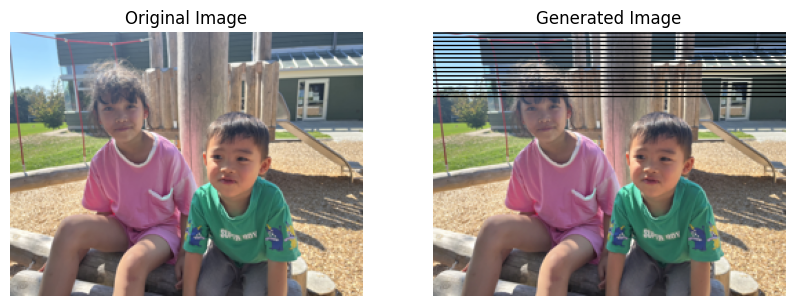

In [80]:
width,height = (256, 192)

pixel_array = generate_image(model, width, height)
print(f"pixel array shape {pixel_array.shape}")
# print(f"pixel array sample {pixel_array[0:5,:]}")
image = Image.fromarray(pixel_array)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
original_img = Image.open("elladali.png").resize((width, height))
ax1.imshow(original_img)
ax1.set_title("Original Image")
ax1.axis('off')
ax2.imshow(image)
ax2.set_title("Generated Image")
ax2.axis('off')
plt.show()


In [75]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ColorPredictor(nn.Module):
    def __init__(self):
        super(ColorPredictor, self).__init__()
        # Added positional encoding and deeper architecture
        self.position_encode = PositionalEncoding(2, L=10)
        self.layers = nn.Sequential(
            nn.Linear(2 + 2*2*10, 256),  # Increased input dim for positional encoding
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.position_encode(x)
        return self.layers(x)

class PositionalEncoding(nn.Module):
    """From NeRF: https://arxiv.org/abs/2003.08934"""
    def __init__(self, input_dim, L=10):
        super().__init__()
        self.L = L
        self.output_dim = input_dim * (2 * L + 1)
        
    def forward(self, x):
        encoded = [x]
        for i in range(self.L):
            encoded.append(torch.sin(2**i * torch.pi * x))
            encoded.append(torch.cos(2**i * torch.pi * x))
        return torch.cat(encoded, dim=-1)

def train(model, X, y, epochs=5000):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    batch_size = 4096  # Reduced batch size
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    lossF = nn.MSELoss()
    best_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = lossF(pred, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step()
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss {avg_loss:.6f}, LR {scheduler.get_last_lr()[0]:.6f}")

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

# Keep generate_training_data and generate_image functions similar, but ensure they use the same positional encoding

# ... (rest of the code remains similar) ...
def generate_training_data(image_path, max_width=800, max_height=600):
  image = Image.open(image_path)

  image = image.convert('RGB')
  original_width, original_height = image.size
  # Calculate the aspect ratio
  aspect_ratio = original_width / original_height
  # Determine new dimensions while maintaining aspect ratio
  
  if original_width > original_height:
    new_width = max_width
    new_height = int(new_width / aspect_ratio)
  else:
    new_height = max_height
    new_width = int(new_height * aspect_ratio)
  print(f"image with {original_width} height {original_height}")
  print(f"new image with {new_width} height {new_height}")
  image = image.resize((new_width, new_height))
  pixels = np.array(image)/255.0
  X = []
  y = []
  for h in range(image.height):
    for w in range(image.width):
      y.append(pixels[h, w])
    
      wn = (w*1.0/image.width) * 2 - 1
      hn = (h*1.0/image.height) * 2 - 1
      X.append([wn, hn])
      

  return (torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(np.array(y, np.float32)))

def generate_image(model, width, height):
    model.eval()
    image = np.zeros((height, width, 3), dtype=np.uint32)
    cs = []
    for i in range(width):
        for j in range(height):
            cs.append([(i*1.0/width)*2-1, (j*1.0/height)*2-1])
    cs_tensor = torch.FloatTensor(cs)
    pred = model(cs_tensor.to(device)).cpu()

    for c,color in zip(cs, pred):
        color_value = color.detach().numpy()
        # converted_color_value = color_value.astype(np.uint32)
        converted_color_value = color_value
        # print(f"color value {color_value} converted {converted_color_value}")
        # print(f"coordinates {c}")
        x = int((c[0]+1.0)/2*width)
        y = int((c[1]+1.0)/2*height)
        image[y, x] = converted_color_value*255
        
    return image.astype(np.uint8)

In [76]:
X,y = generate_training_data("elladali.png", 256, 256)

model = ColorPredictor().to(device)

X = X.to(device)
y = y.to(device)

train(model, X, y, epochs=5000)

image with 4032 height 3024
new image with 256 height 192
Epoch 0, Loss 0.064811, LR 0.001000
Epoch 50, Loss 0.002505, LR 0.001000
Epoch 100, Loss 0.001847, LR 0.000999
Epoch 150, Loss 0.001232, LR 0.000998
Epoch 200, Loss 0.000954, LR 0.000996
Epoch 250, Loss 0.000868, LR 0.000994
Epoch 300, Loss 0.000919, LR 0.000991
Epoch 350, Loss 0.000495, LR 0.000988
Epoch 400, Loss 0.000851, LR 0.000984
Epoch 450, Loss 0.000773, LR 0.000980
Epoch 500, Loss 0.000351, LR 0.000975
Epoch 550, Loss 0.000497, LR 0.000970
Epoch 600, Loss 0.000413, LR 0.000965
Epoch 650, Loss 0.000408, LR 0.000959
Epoch 700, Loss 0.000225, LR 0.000952
Epoch 750, Loss 0.000215, LR 0.000945
Epoch 800, Loss 0.000251, LR 0.000938
Epoch 850, Loss 0.000170, LR 0.000930
Epoch 900, Loss 0.000116, LR 0.000922
Epoch 950, Loss 0.000203, LR 0.000913
Epoch 1000, Loss 0.000184, LR 0.000904
Epoch 1050, Loss 0.000123, LR 0.000895
Epoch 1100, Loss 0.000275, LR 0.000885
Epoch 1150, Loss 0.000166, LR 0.000875
Epoch 1200, Loss 0.000086, LR

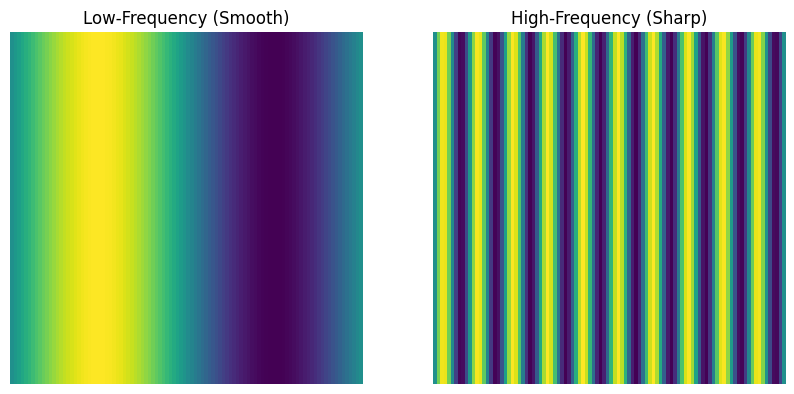

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Low-frequency pattern (smooth gradient)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
low_freq = np.sin(2 * np.pi * X)  # Smooth variation

# High-frequency pattern (sharp changes)
high_freq = np.sin(20 * np.pi * X)  # Rapid variation

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(low_freq, cmap='viridis')
plt.title("Low-Frequency (Smooth)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(high_freq, cmap='viridis')
plt.title("High-Frequency (Sharp)")
plt.axis('off')

plt.show()